# Linear Regression

https://docs.pymc.io/notebooks/getting_started.html#A-Motivating-Example:-Linear-Regression (and a mix of https://docs.pymc.io/notebooks/api_quickstart.html)

We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $μ$ that is a linear function of two predictor variables, $X1$ and $X2$.

$$\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2 \\
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned}
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert \mathcal{N}(0, 1) {\rvert} \\
\end{aligned}$$


https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd 

The key idea is pretty simple: in the Bayesian worldview, everything has a probability distribution attached to it, including model parameters (weights and biases in NNs). In programming languages, we have variables that can take a specific value and every-time you access the variable, you get the same value. In contrast to that, in the Bayesian world, we have similar entities that are called random variables that give a different value every time you access it. So if X is a random variable representing the normal distribution, every time you access X, it’ll have a different value.

This process of getting a new value from a random variable is called sampling. What value comes out depends on the random variable’s associated probability distribution. The wider the probability distribution associated with a random variable, the more uncertainty there is regarding its value because it could then take any value as per the (wide) probability distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize random number generator
np.random.seed(123)

import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Utilisateurs\a557847\AppData\Local\Continuum\anaconda3\envs\pymc3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.5


In [2]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Text(0.5, 0, 'X2')

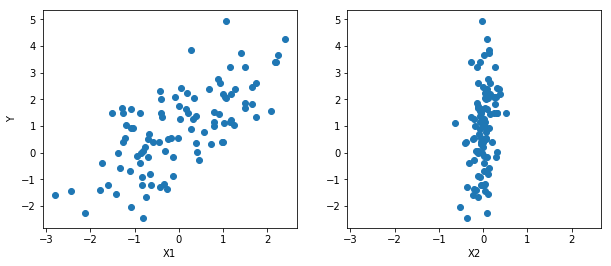

In [3]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2')

In [4]:
with pm.Model() as model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [5]:
model

In [7]:
model.basic_RVs

[alpha, beta, sigma_log__, Y_obs]

In [8]:
model.free_RVs

[alpha, beta, sigma_log__]

In [9]:
model.observed_RVs

[Y_obs]

In [16]:
model.logp({'alpha': 0, 'beta':[0, 0], 'sigma_log__':0})

array(-260.68185412)

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the _maximum a posteriori_ (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

#### Maximum a posteriori methods

The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with _the find_MAP_ function.

In [17]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 53.98it/s]


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma': array(0.96298858),
 'sigma_log__': array(-0.03771373)}

In [19]:
with model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


ValueError: must use protocol 4 or greater to copy this object; since __getnewargs_ex__ returned keyword arguments.